# Baseline models on binned data

In [2]:
import re

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier


import scikitplot as skplt

import xgboost as xgb

from utils.evaluation import evaluate_model
from utils.report import report_by_sections
from utils.features import bin_numeric_feature

In [3]:
train_data = pd.read_csv("data/train_data.csv", parse_dates=["block_time"])

In [4]:
validation_data = pd.read_csv("data/validation_data.csv", parse_dates=["block_time"])

In [5]:
binned_features = pd.read_csv("binned_features.csv")

In [6]:
feature_breaks = {
    f: list(binned_features.loc[binned_features["feature"] == f, "to"].dropna())
    for f in binned_features["feature"].drop_duplicates()
}

## 1 Create train sample balanced between cases

In [11]:
tx_count = train_data.groupby("file_name")["transaction_id"].nunique()

Exclude cases with very few transactions

In [12]:
tx_count[tx_count < 20]

file_name
Audius.csv                   5
CompounderFinance004.csv    14
CompounderFinance005.csv     3
Lympo002.csv                 3
Taylor001.csv                7
dxHub001.csv                18
Name: transaction_id, dtype: int64

In [13]:
files_to_exclude = list(tx_count[tx_count < 20].index)
files_to_exclude

['Audius.csv',
 'CompounderFinance004.csv',
 'CompounderFinance005.csv',
 'Lympo002.csv',
 'Taylor001.csv',
 'dxHub001.csv']

In [14]:
file_names = train_data["file_name"].drop_duplicates()

In [15]:
target_fer_file = 50
ref_per_file = 300
samples = []
np.random.seed(1234)
for f in file_names:
    if f not in files_to_exclude:
        df = train_data.loc[train_data["file_name"] == f, :]
        samples.append(
            df.loc[df["label"] == 1, :].sample(target_fer_file, replace=True)
        )
        samples.append(df.loc[df["label"] == 0, :].sample(ref_per_file, replace=True))
train_sample = pd.concat(samples).reset_index(drop=True)

In [16]:
train_sample.shape

(39200, 116)

In [17]:
train_sample["label"].value_counts()

0    33600
1     5600
Name: label, dtype: int64

## 2 binned features (based on binned_features.csv scores)

When some bins have low count, it can be useful to merge them with neighboring bins to get better statistics.

In [266]:
override_breaks = {
    "snd_rcv_mean_amt_usd_tx_std_log_to_median_ratio": [-3.755, -0.888, 0.74]
}

In [267]:
for f in override_breaks:
    feature_breaks[f] = override_breaks[f]

In [34]:
binned_features["cnt"] = binned_features["tgt_cnt"] + binned_features["ref_cnt"]

In [35]:
filtered_binned_features = binned_features.loc[binned_features["cnt"] > 50, :]

In [36]:
top_positive = filtered_binned_features.sort_values("ratio").tail(25)
top_negative = filtered_binned_features.sort_values("ratio").head(25)
selected_feature_breaks = pd.concat(
    [
        top_positive["feature"] + "_" + top_positive["bin_name"],
        top_negative["feature"] + "_" + top_negative["bin_name"],
    ]
)

In [37]:
print('"' + '",\n"'.join(sorted(selected_feature_breaks)) + '"')

"snd_rcv_amt_usd_sum_tx_max_log_to_median_ratio_bin0",
"snd_rcv_amt_usd_sum_tx_max_log_to_median_ratio_bin4",
"snd_rcv_amt_usd_sum_tx_mean_log_to_median_ratio_bin0",
"snd_rcv_amt_usd_sum_tx_mean_log_to_median_ratio_bin4",
"snd_rcv_amt_usd_sum_tx_median_log_to_median_ratio_bin0",
"snd_rcv_amt_usd_sum_tx_median_log_to_median_ratio_bin4",
"snd_rcv_amt_usd_sum_tx_min_log_to_median_ratio_bin0",
"snd_rcv_amt_usd_sum_tx_min_log_to_median_ratio_bin4",
"snd_rcv_amt_usd_sum_tx_std_log_to_median_ratio_bin4",
"snd_rcv_life_time_sec_tx_max_log_to_median_ratio_bin4",
"snd_rcv_life_time_sec_tx_mean_log_to_median_ratio_bin4",
"snd_rcv_life_time_sec_tx_median_log_to_median_ratio_bin4",
"snd_rcv_life_time_sec_tx_std_log_to_median_ratio_bin0",
"snd_rcv_life_time_sec_tx_std_log_to_median_ratio_bin4",
"snd_rcv_life_time_sec_tx_sum_log_to_median_ratio_bin4",
"snd_rcv_mean_amt_usd_tx_max_log_to_median_ratio_bin0",
"snd_rcv_mean_amt_usd_tx_max_log_to_median_ratio_bin1",
"snd_rcv_mean_amt_usd_tx_max_log_to_med

In [306]:
selected_feature_breaks = [
    "snd_rcv_amt_usd_sum_tx_max_log_to_median_ratio_bin0",
    "snd_rcv_amt_usd_sum_tx_max_log_to_median_ratio_bin1",
    "snd_rcv_amt_usd_sum_tx_max_log_to_median_ratio_bin4",
    # "snd_rcv_amt_usd_sum_tx_mean_log_to_median_ratio_bin0",
    # "snd_rcv_amt_usd_sum_tx_mean_log_to_median_ratio_bin4",
    "snd_rcv_amt_usd_sum_tx_median_log_to_median_ratio_bin0",
    "snd_rcv_amt_usd_sum_tx_median_log_to_median_ratio_bin4",
    "snd_rcv_amt_usd_sum_tx_min_log_to_median_ratio_bin0",
    "snd_rcv_amt_usd_sum_tx_min_log_to_median_ratio_bin4",
    "snd_rcv_amt_usd_sum_tx_std_log_to_median_ratio_bin4",
    "snd_rcv_life_time_sec_tx_max_log_to_median_ratio_bin4",
    "snd_rcv_life_time_sec_tx_max_log_to_median_ratio_bin1",
    "snd_rcv_life_time_sec_tx_max_log_to_median_ratio_bin4",
    "snd_rcv_life_time_sec_tx_mean_log_to_median_ratio_bin4",
    "snd_rcv_life_time_sec_tx_median_log_to_median_ratio_bin4",
    # "snd_rcv_life_time_sec_tx_std_log_to_median_ratio_bin0",
    # "snd_rcv_life_time_sec_tx_std_log_to_median_ratio_bin4",
    # "snd_rcv_life_time_sec_tx_sum_log_to_median_ratio_bin4",
    "snd_rcv_mean_amt_usd_tx_max_log_to_median_ratio_bin0",
    "snd_rcv_mean_amt_usd_tx_max_log_to_median_ratio_bin1",
    "snd_rcv_mean_amt_usd_tx_max_log_to_median_ratio_bin4",
    # "snd_rcv_mean_amt_usd_tx_mean_log_to_median_ratio_bin0",
    # "snd_rcv_mean_amt_usd_tx_mean_log_to_median_ratio_bin1",
    # "snd_rcv_mean_amt_usd_tx_mean_log_to_median_ratio_bin4",
    "snd_rcv_mean_amt_usd_tx_median_log_to_median_ratio_bin0",
    "snd_rcv_mean_amt_usd_tx_median_log_to_median_ratio_bin1",
    "snd_rcv_mean_amt_usd_tx_median_log_to_median_ratio_bin4",
    "snd_rcv_mean_amt_usd_tx_min_log_to_median_ratio_bin0",
    "snd_rcv_mean_amt_usd_tx_min_log_to_median_ratio_bin1",
    "snd_rcv_mean_amt_usd_tx_min_log_to_median_ratio_bin4",
    # "snd_rcv_mean_amt_usd_tx_std_log_to_median_ratio_bin1",
    "snd_rcv_mean_amt_usd_tx_std_log_to_median_ratio_bin3",
    "snd_rcv_mean_amt_usd_tx_sum_log_to_median_ratio_bin0",
    "snd_rcv_mean_amt_usd_tx_sum_log_to_median_ratio_bin1",
    "snd_rcv_mean_amt_usd_tx_sum_log_to_median_ratio_bin2",
    "snd_rcv_mean_amt_usd_tx_sum_log_to_median_ratio_bin4",
    "snd_rcv_mean_time_diff_sec_tx_max_log_to_median_ratio_bin0",
    # snd_rcv_mean_time_diff_sec_tx_mean_log_to_median_ratio_bin0",
    "snd_rcv_mean_time_diff_sec_tx_median_log_to_median_ratio_bin0",
    "snd_rcv_mean_time_diff_sec_tx_min_log_to_median_ratio_bin0",
    # "snd_rcv_mean_time_diff_sec_tx_std_log_to_median_ratio_bin3",
    # "snd_rcv_mean_time_diff_sec_tx_sum_log_to_median_ratio_bin4",
    "snd_rcv_time_diff_sec_tx_max_log_to_median_ratio_bin0",
    # "snd_rcv_time_diff_sec_tx_mean_log_to_median_ratio_bin0",
    "snd_rcv_time_diff_sec_tx_median_log_to_median_ratio_bin0",
    "snd_rcv_time_diff_sec_tx_min_log_to_median_ratio_bin0",
    "snd_rcv_time_diff_sec_tx_min_log_to_median_ratio_bin3",
    "snd_rcv_time_diff_sec_tx_min_log_to_median_ratio_bin4",
    # "snd_rcv_time_diff_sec_tx_std_log_to_median_ratio_bin3",
    # "snd_rcv_time_diff_sec_tx_std_log_to_median_ratio_bin4",
    "snd_rcv_tkn_type_cnt_tx_max_log_to_median_ratio_bin4",
    # "snd_rcv_tkn_type_cnt_tx_mean_log_to_median_ratio_bin4",
    "snd_rcv_tkn_type_cnt_tx_median_log_to_median_ratio_bin4",
    "snd_rcv_tkn_type_cnt_tx_min_log_to_median_ratio_bin4",
    # "snd_rcv_tkn_type_cnt_tx_std_log_to_median_ratio_bin1",
    "snd_rcv_tkn_type_cnt_tx_sum_log_to_median_ratio_bin4",
    "snd_rcv_tx_cnt_tx_mean_log_to_median_ratio_bin4",
    "snd_rcv_tx_cnt_tx_max_log_to_median_ratio_bin0",
    # "snd_rcv_tx_cnt_tx_std_log_to_median_ratio_bin3",
    # "snd_rcv_tx_cnt_tx_sum_log_to_median_ratio_bin4"
]

In [307]:
selected_features = list(
    set([re.sub("_bin\d+$", "", x) for x in selected_feature_breaks])
)

In [308]:
model_train_sample = pd.concat(
    [
        bin_numeric_feature(train_sample[f], feature_breaks[f])
        for f in selected_features
    ],
    axis=1,
).loc[:, selected_feature_breaks]

model_train_data = pd.concat(
    [bin_numeric_feature(train_data[f], feature_breaks[f]) for f in selected_features],
    axis=1,
).loc[:, selected_feature_breaks]

In [309]:
model_train_sample["label"] = train_sample["label"]

## 2 Model training and evaluation

In [361]:
X = model_train_sample.loc[:, selected_feature_breaks]
y = model_train_sample["label"]
class_weight = {0: 1, 1: 2.5}
# class_weight='balanced'
# model = LogisticRegression(class_weight=class_weight).fit(X, y)
# model = SVC(class_weight='balanced').fit(X, y)
# model = RandomForestClassifier(class_weight=class_weight).fit(X, y)
model = GradientBoostingClassifier(n_estimators=50).fit(X, y)

In [362]:
train_pred_label = model.predict(model_train_sample.loc[:, selected_feature_breaks])
train_true_label = model_train_sample["label"]

recall: 0.599, precision: 0.815, specificity: 0.977


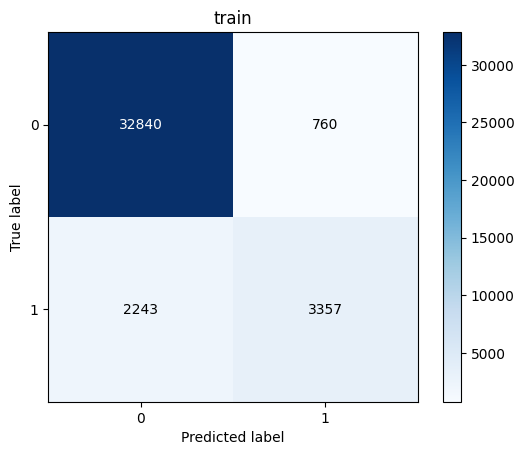

In [363]:
train_metrics = evaluate_model(
    train_true_label, train_pred_label, confusion_title="train"
)
print(
    f"recall: {train_metrics['recall']}, "
    + f"precision: {train_metrics['precision']}, "
    + f"specificity: {train_metrics['specificity']}"
)

In [364]:
model_val_data = pd.concat(
    [
        bin_numeric_feature(validation_data[f], feature_breaks[f])
        for f in selected_features
    ],
    axis=1,
).loc[:, selected_feature_breaks]

In [365]:
val_pred_label = model.predict(model_val_data.loc[:, selected_feature_breaks])
val_true_label = validation_data["label"]

recall: 0.626, precision: 0.072, specificity: 0.984


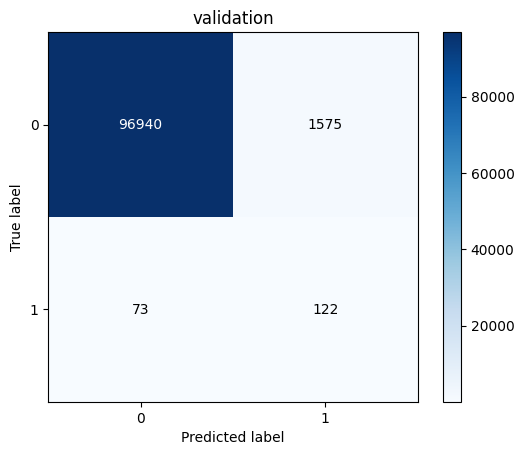

In [366]:
val_metrics = evaluate_model(
    val_true_label, val_pred_label, confusion_title="validation"
)
print(
    f"recall: {val_metrics['recall']}, "
    + f"precision: {val_metrics['precision']}, "
    + f"specificity: {val_metrics['specificity']}"
)

## 4 Report

In [367]:
if type(model) is LogisticRegression:
    model_coefs = (
        pd.DataFrame(
            zip(selected_feature_breaks, model.coef_[0]), columns=["feature", "coef"]
        )
        .sort_values("coef")
        .reset_index(drop=True)
    )
    print(model_coefs.sort_values("coef", ascending=False).head())
    print(model_coefs.sort_values("coef", ascending=False).tail())

In [368]:
if type(model) in {RandomForestClassifier, GradientBoostingClassifier}:
    feature_importance = pd.DataFrame(
        zip(selected_feature_breaks, model.feature_importances_),
        columns=["feature", "importance"],
    )
    print(feature_importance.sort_values("importance", ascending=False).head())

                                              feature  importance
20  snd_rcv_mean_amt_usd_tx_min_log_to_median_rati...    0.306148
28  snd_rcv_mean_time_diff_sec_tx_median_log_to_me...    0.271420
40     snd_rcv_tx_cnt_tx_max_log_to_median_ratio_bin0    0.093440
16  snd_rcv_mean_amt_usd_tx_median_log_to_median_r...    0.044213
23  snd_rcv_mean_amt_usd_tx_sum_log_to_median_rati...    0.031319


In [369]:
train_pred_label = model.predict(model_train_data.loc[:, selected_feature_breaks])

In [370]:
train_results = train_data.loc[:, ["file_name", "label"]].copy()
train_results["pred_label"] = train_pred_label
train_results["exp_part"] = "train"

In [371]:
validation_results = validation_data.loc[:, ["file_name", "label"]]
validation_results["pred_label"] = val_pred_label
validation_results["exp_part"] = "validation"

In [372]:
model_result = pd.concat([train_results, validation_results])

In [373]:
cases = pd.read_csv("Validated_V0_Desriptions.csv").rename(
    {"File Names": "file_name", "Exploit Types": "exploit_type"}, axis=1
)
cases["file_name"] += ".csv"
cases = cases.loc[
    :, ["file_name", "exploit_type", "Minimum Time", "train/test splits", "Attack Link"]
]

In [374]:
model_results = cases.merge(model_result)

In [375]:
file_report, exploit_report = report_by_sections(model_results)

In [376]:
exploit_report

,exploit_type,exp_part,files,tp,fp,tn,fn,recall,precision
0,Access Control,train,54,1222,20974,369894,86,0.934251,0.055055
1,Access Control,validation,11,98,985,58475,36,0.731343,0.090489
2,Flash Loan Attack,train,18,18,759,59311,1,0.947368,0.023166
3,Flash Loan Attack,validation,5,16,553,25833,2,0.888889,0.028120
4,Phishing,train,16,2,162,9021,24,0.076923,0.012195
5,Phishing,validation,5,1,2,244,19,0.050000,0.333333
6,Price Manupilation,train,5,5,9,649,0,1.000000,0.357143
7,Price Manupilation,validation,1,1,16,580,0,1.000000,0.058824
8,Rug pull,train,25,174,801,55300,139,0.555911,0.178462
9,Rug pull,validation,6,6,19,11808,16,0.272727,0.240000


In [377]:
file_report.groupby("exp_part")["catch_any"].mean()

exp_part
train         0.618644
validation    0.500000
Name: catch_any, dtype: float64